In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# ========================
# 2. Load the Data
# ========================

train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")
test = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Test.csv")

print("Train Shape:", train.shape)
train.head()

# Data Cleaning

# Remove duplicates
train = train.drop_duplicates()
test = test.drop_duplicates()

# Handle missing values
# For numeric columns, fill with median
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    train[col] = train[col].fillna(train[col].median())
    if col in test.columns:
        test[col] = test[col].fillna(test[col].median())

# For categorical columns, fill with mode
for col in train.select_dtypes(include=['object']).columns:
    train[col] = train[col].fillna(train[col].mode()[0])
    if col in test.columns:
        test[col] = test[col].fillna(test[col].mode()[0])

# Remove columns with too many missing values (optional)
missing_thresh = 0.5
train = train.loc[:, train.isnull().mean() < missing_thresh]
test = test.loc[:, test.isnull().mean() < missing_thresh]

print("Train shape after cleaning:", train.shape)

Train Shape: (2100, 27)
Train shape after cleaning: (2100, 27)


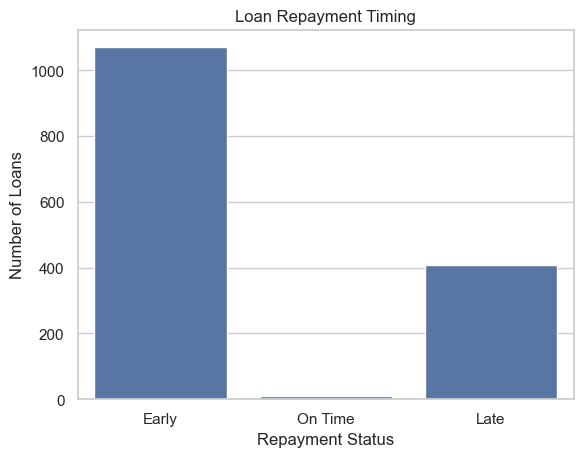

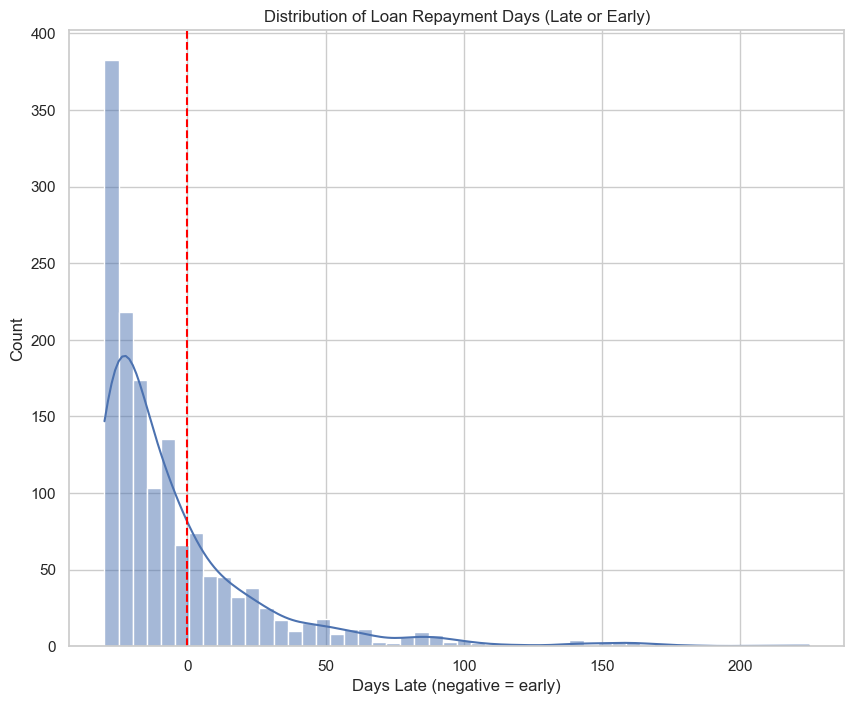

In [19]:
# ========================
# EDA: Loan Repayment vs Due Date
# ========================

# Load original data again if columns were dropped
full_train = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\DS\\Project\\Train.csv")

# Ensure both date columns exist
if 'PaidOnDate' in full_train.columns and 'DueDate' in full_train.columns:
    
    # Convert to datetime
    full_train['PaidOnDate'] = pd.to_datetime(full_train['PaidOnDate'], errors='coerce')
    full_train['DueDate'] = pd.to_datetime(full_train['DueDate'], errors='coerce')
    
    # Drop rows with invalid or missing dates
    full_train.dropna(subset=['PaidOnDate', 'DueDate'], inplace=True)

    # Calculate days early/late
    full_train['Days_Late'] = (full_train['PaidOnDate'] - full_train['DueDate']).dt.days

    # Add repayment status
    full_train['Repayment_Status'] = full_train['Days_Late'].apply(
        lambda x: 'On Time' if x == 0 else ('Late' if x > 0 else 'Early')
    )

    # Distribution of repayment status
    sns.countplot(x='Repayment_Status', data=full_train, order=['Early', 'On Time', 'Late'])
    plt.title('Loan Repayment Timing')
    plt.xlabel('Repayment Status')
    plt.ylabel('Number of Loans')
    plt.show()

    # Histogram of days late or early
    plt.figure(figsize=(10, 8))
    sns.histplot(full_train['Days_Late'], bins=50, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title('Distribution of Loan Repayment Days (Late or Early)')
    plt.xlabel('Days Late (negative = early)')
    plt.ylabel('Count')
    plt.show()

    # Boxplot of lateness by Good_Bad_flag if available
    if 'Good_Bad_flag' in full_train.columns:
        plt.figure(figsize=(10, 8))
        sns.boxplot(x='Good_Bad_flag', y='Days_Late', data=full_train)
        plt.title('Days Late vs Good_Bad_flag')
        plt.show()
else:
    print("Required columns 'PaidOnDate' or 'DueDate' not found in the dataset.")


Train shape: (2100, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerId             2100 non-null   object 
 1   TransactionStartTime   2100 non-null   object 
 2   Value                  2100 non-null   float64
 3   Amount                 2100 non-null   float64
 4   TransactionId          2100 non-null   object 
 5   BatchId                2100 non-null   object 
 6   SubscriptionId         2100 non-null   object 
 7   CurrencyCode           2100 non-null   object 
 8   CountryCode            2100 non-null   int64  
 9   ProviderId             2100 non-null   object 
 10  ProductId              2100 non-null   object 
 11  ProductCategory        2100 non-null   object 
 12  ChannelId              2100 non-null   object 
 13  TransactionStatus      2100 non-null   int64  
 14  IssuedDateLoan         2100 non-

C:\Users\user\AppData\Local\Temp\ipykernel_5772\3892056026.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])


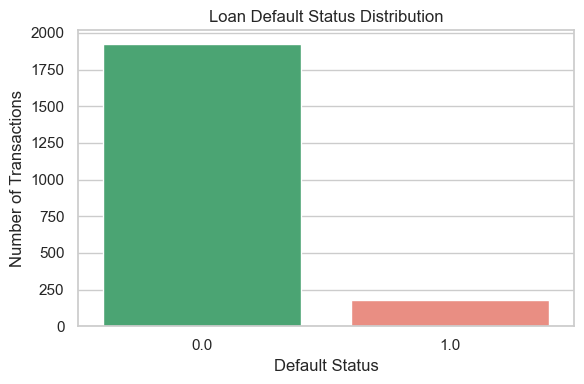

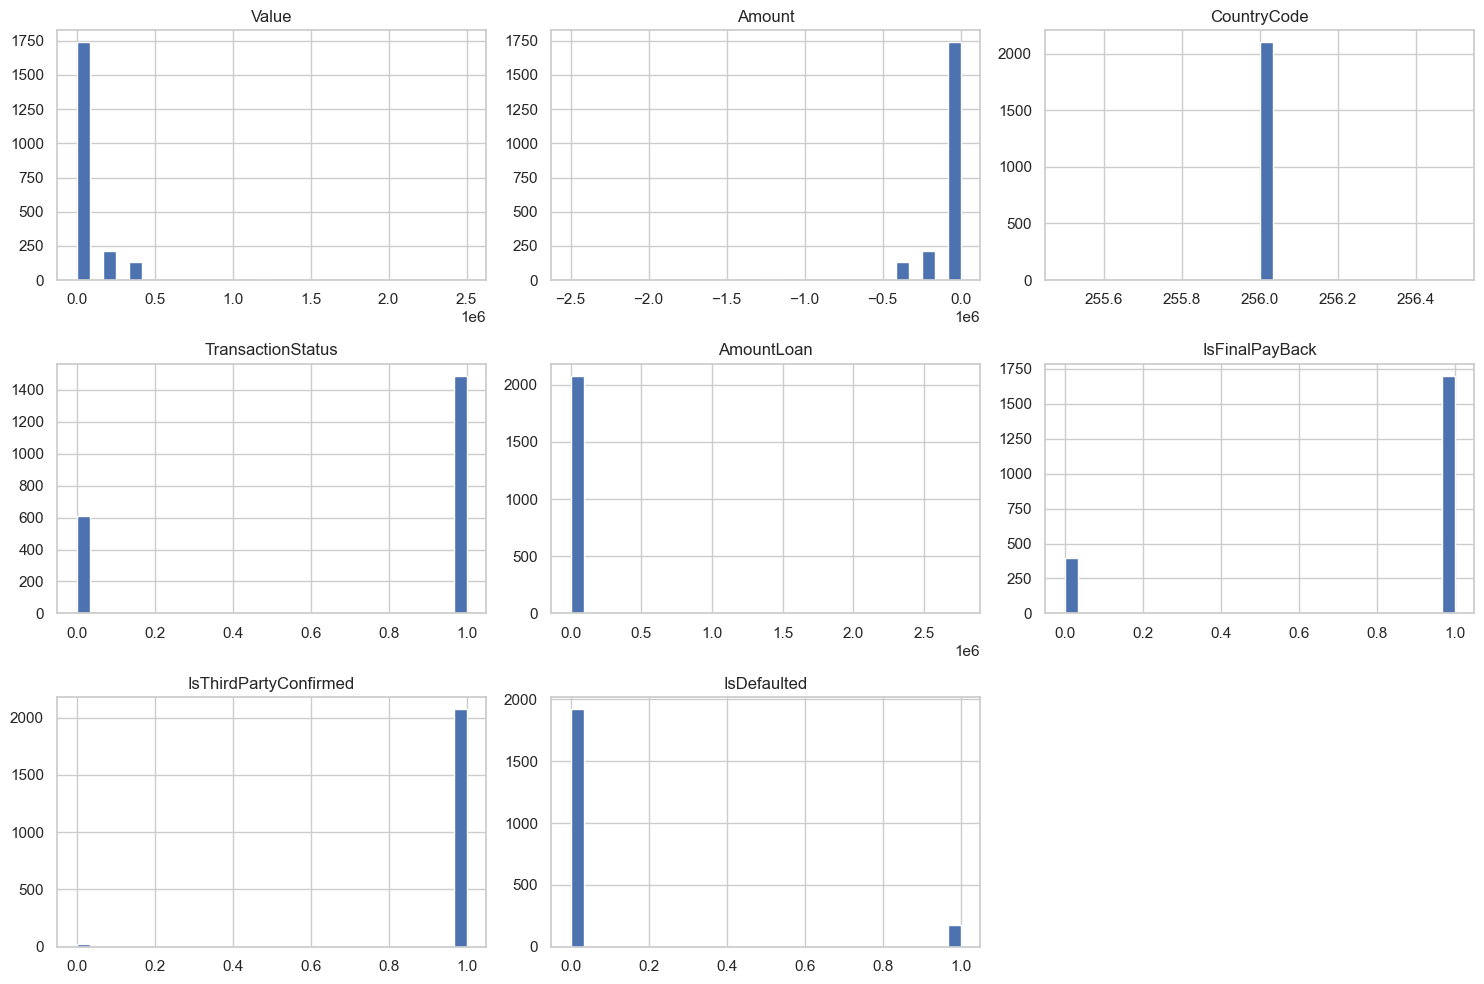

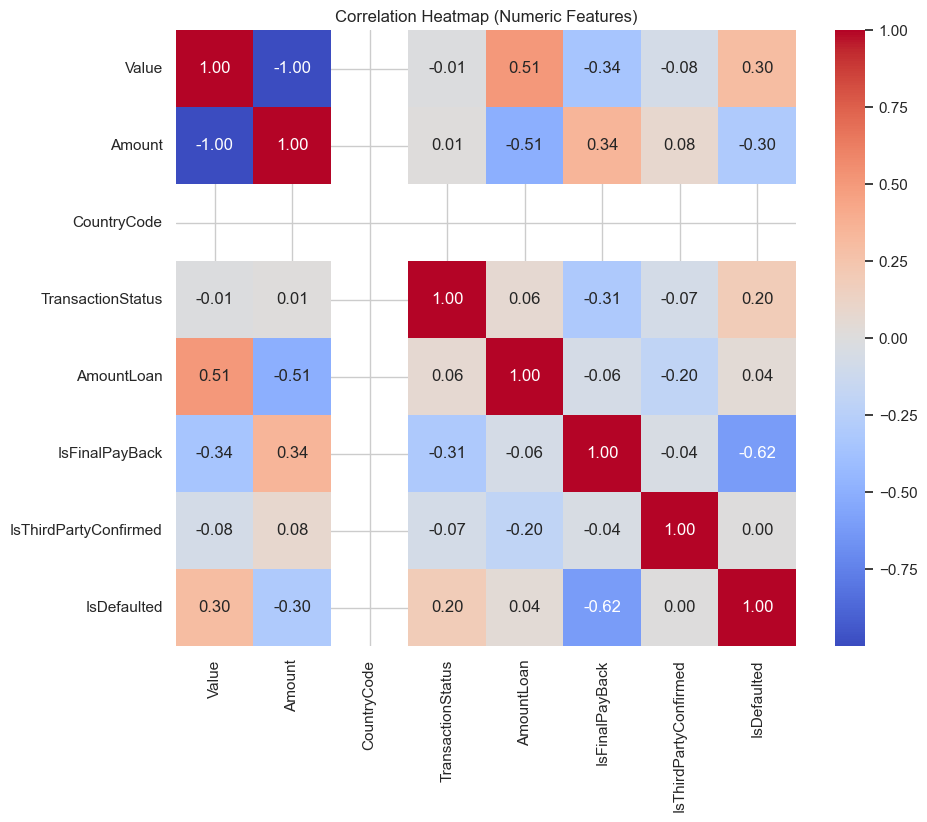

C:\Users\user\AppData\Local\Temp\ipykernel_5772\3892056026.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='IsDefaulted', y='Value', data=train, palette='Set2', inner='quartile')


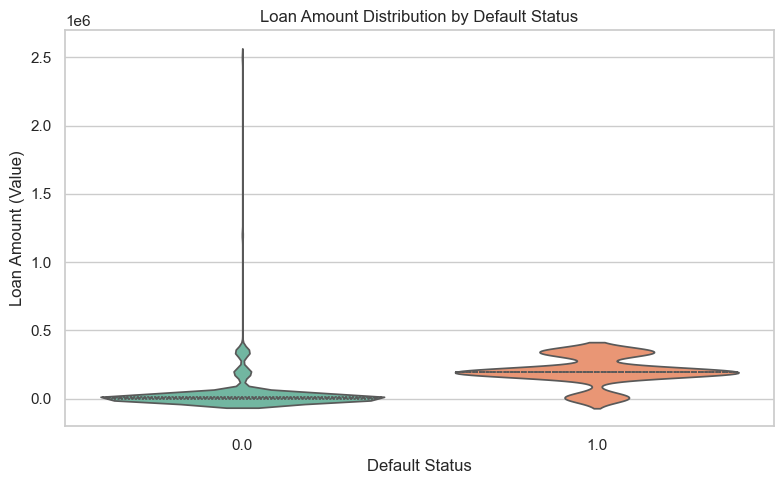

In [20]:
# EDA for the train dataset
# 1. Basic info and statistics
print("Train shape:", train.shape)
print(train.info())
print(train.describe())

# 2. Check for missing values
missing = train.isnull().sum()
print("Missing values per column:\n", missing[missing > 0])

# 3. Target variable distribution
if 'IsDefaulted' in train.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='IsDefaulted', data=train, palette=['mediumseagreen', 'salmon'])
    plt.title('Loan Default Status Distribution')
    plt.xlabel('Default Status')
    plt.ylabel('Number of Transactions')
    plt.tight_layout()
    plt.show()

# 4. Numeric feature distributions
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
train[num_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# 6. Example: Relationship between loan amount and default
if 'Value' in train.columns and 'IsDefaulted' in train.columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='IsDefaulted', y='Value', data=train, palette='Set2', inner='quartile')
    plt.title('Loan Amount Distribution by Default Status')
    plt.xlabel('Default Status')
    plt.ylabel('Loan Amount (Value)')
    plt.tight_layout()
    plt.show()

In [23]:
# Split train dataset: 70% training, 15% validation, 15% test
train_set, temp_set = train_test_split(
    train, test_size=0.3, random_state=42,
    stratify=train['IsDefaulted'] if 'IsDefaulted' in train.columns else None
)
val_set, test_set = train_test_split(
    temp_set, test_size=0.5, random_state=42,
    stratify=temp_set['IsDefaulted'] if 'IsDefaulted' in temp_set.columns else None
)

print("Training set shape:", train_set.shape)
print("Validation set shape:", val_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (1470, 27)
Validation set shape: (315, 27)
Test set shape: (315, 27)


In [24]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

target = 'Good_Bad_flag'
if target in num_cols:
    num_cols.remove(target)

le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
# Only use numeric columns for modeling
features = [col for col in train_set.columns if col not in ['IsDefaulted', 'Good_Bad_flag'] and train_set[col].dtype in [np.int64, np.float64]]

X_train = train_set[features]
y_train = train_set['IsDefaulted']
X_val = val_set[features]
y_val = val_set['IsDefaulted']

In [ ]:
# Ensure IsDefaulted is integer and binary
train['IsDefaulted'] = pd.to_numeric(train['IsDefaulted'], errors='coerce').fillna(0).astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Only use numeric columns for modeling
features = [col for col in train_set.columns if col not in ['IsDefaulted', 'Good_Bad_flag'] and train_set[col].dtype in [np.int64, np.float64]]

X_train = train_set[features]
y_train = train_set['IsDefaulted']
X_val = val_set[features]
y_val = val_set['IsDefaulted']

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
print("Logistic Regression Results:")
print(classification_report(y_val, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_val, logreg.predict_proba(X_val)[:, 1]))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("Random Forest Results:")
print(classification_report(y_val, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]))

Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       288
         1.0       0.56      0.19      0.28        27

    accuracy                           0.92       315
   macro avg       0.74      0.59      0.62       315
weighted avg       0.90      0.92      0.90       315

ROC-AUC: 0.9467592592592593
Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       288
         1.0       0.87      0.74      0.80        27

    accuracy                           0.97       315
   macro avg       0.92      0.87      0.89       315
weighted avg       0.97      0.97      0.97       315

ROC-AUC: 0.9619341563786007


In [40]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Forest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=10, scoring='roc_auc', 
    cv=3, random_state=42, n_jobs=-1
)
# Drop rows with NaN or inf in X_train or y_train
mask = (
    (~X_train.isnull().any(axis=1)) &
    (~X_train.isin([np.inf, -np.inf]).any(axis=1)) &
    (~y_train.isnull()) &
    (~y_train.isin([np.inf, -np.inf]))
)
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

# Convert y_train_clean to binary (0/1)
# If your IsDefaulted is 0/1, this will work; adjust threshold if needed
y_train_clean = (y_train_clean > 0).astype(int)

# Reset index to align
X_train_clean = X_train_clean.reset_index(drop=True)
y_train_clean = y_train_clean.reset_index(drop=True)

print("Shapes after cleaning:", X_train_clean.shape, y_train_clean.shape)
print("Unique y_train_clean after binarization:", y_train_clean.unique())

# Now fit
random_search.fit(X_train_clean, y_train_clean)

print("Best parameters found:", random_search.best_params_)
print("Best ROC-AUC score (CV):", random_search.best_score_)

# Validate on the validation set
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_val)

# Binarize y_val to match y_pred_rf
y_val_bin = (y_val > 0).astype(int)

print("Validation Results with Best Random Forest:")
print(classification_report(y_val_bin, y_pred_rf))
print("Validation ROC-AUC:", roc_auc_score(y_val_bin, best_rf.predict_proba(X_val)[:, 1]))

Shapes after cleaning: (1470, 26) (1470,)
Unique y_train_clean after binarization: [0 1]
Best parameters found: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Best ROC-AUC score (CV): 0.9915369406981562
Validation Results with Best Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       288
           1       1.00      0.78      0.88        27

    accuracy                           0.98       315
   macro avg       0.99      0.89      0.93       315
weighted avg       0.98      0.98      0.98       315

Validation ROC-AUC: 0.9980709876543211


In [42]:
# Model evaluation using the remaining 15% test data

# Prepare test features (same preprocessing as train/validation)
test_features = [col for col in test_set.columns if col in X_train.columns]
X_test = test_set[test_features]
y_test = test_set['IsDefaulted']

# Binarize y_test to match model output (0/1)
y_test_bin = (y_test > 0).astype(int)

# Predict and evaluate
y_pred_test = best_rf.predict(X_test)
print("Test Results with Best Random Forest:")
print(classification_report(y_test_bin, y_pred_test))
print("Test ROC-AUC:", roc_auc_score(y_test_bin, best_rf.predict_proba(X_test)[:, 1]))

Test Results with Best Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.88      0.85      0.86        26

    accuracy                           0.98       315
   macro avg       0.93      0.92      0.93       315
weighted avg       0.98      0.98      0.98       315

Test ROC-AUC: 0.9873569337237157


In [45]:
%pip install lime

import lime
import lime.lime_tabular

# Use the same features as your model
feature_names = X_train.columns.tolist()
class_names = ['Not Defaulted', 'Defaulted']

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Pick an instance from your validation set to explain
i = 0  # You can change this index to explain a different sample
exp = explainer.explain_instance(
    data_row=X_val.iloc[i].values,
    predict_fn=best_rf.predict_proba
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)

Note: you may need to restart the kernel to use updated packages.Collecting lime
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=d32aa42aba1362c026c422a7724af80baf483fc0c4c7c20459750f631a5805ac
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\7c\04\5c\157dc9106512a6c7a30653ec064490c94a49e0fc8f63d19ab9
Successfully built lime



  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
c:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
